**1-Data Preparation**


---


Resize Images


In [2]:
from PIL import Image
import os

def resize_images(input_dir,  target_size=(512, 512)):
    

    for filename in os.listdir(input_dir):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(input_dir, filename)
            img = Image.open(img_path)
            resized_img = img.resize(target_size, Image.LANCZOS)
            output_path = os.path.join(input_dir, filename)
            resized_img.save(output_path)

input_directory = r'C:\Users\Ziad\Desktop\dataset'
resize_images(input_directory)


**Normailze Pixel Values**

In [5]:
import numpy as np
from PIL import Image
import os

resized_dataset_path = r'C:\Users\Ziad\Desktop\dataset'
# Function to normalize pixel values and save the normalized image
def normalize_and_save(image_path):
    with Image.open(image_path) as img:
        # Convert image to numpy array and normalize pixel values
        img_array = np.array(img) / 255.0
        # Save the normalized image
        normalized_img = Image.fromarray((img_array * 255).astype('uint8'))
        normalized_img.save(image_path)

# Check if resized_dataset_path is a directory
if os.path.isdir(resized_dataset_path):
    # Iterate through each category in the directory
    for category in os.listdir(resized_dataset_path):
        category_path = os.path.join(resized_dataset_path, category)
        # Check if category_path is a directory
        if os.path.isdir(category_path):
            # Iterate through each image in the category directory
            for image_name in os.listdir(category_path):
                image_path = os.path.join(category_path, image_name)
                # Normalize and save the image
                normalize_and_save(image_path)
        else:
            # If category_path is a file, normalize and save the image directly
            normalize_and_save(category_path)
else:
    # If resized_dataset_path is a file, normalize and save the image directly
    normalize_and_save(resized_dataset_path)


**Split Data**

In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the path to your dataset
dataset_path = r'C:\Users\Ziad\Desktop\dataset'

# Get the list of all image files in the dataset directory with .png extension
image_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.png')]

# Check if there are any image files in the dataset directory
if len(image_files) == 0:
    print("No image files found in the dataset directory.")
else:
    # Define the target directories for training, validation, and testing
    train_dir = os.path.join(dataset_path, 'train')
    val_dir = os.path.join(dataset_path, 'val')
    test_dir = os.path.join(dataset_path, 'test')

    # Create the target directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Split the dataset into training, validation, and testing sets
    train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)
    val_files, test_files = train_test_split(test_files, test_size=0.5, random_state=42)

    # Move files to the respective directories
    for file in train_files:
        shutil.move(file, os.path.join(train_dir, os.path.basename(file)))

    for file in val_files:
        shutil.move(file, os.path.join(val_dir, os.path.basename(file)))

    for file in test_files:
        shutil.move(file, os.path.join(test_dir, os.path.basename(file)))


Augmentation

In [8]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
base_dir = r'C:\Users\Ziad\Desktop\dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Define the new target size
new_target_size = (512, 512)

# Image preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow images from directories and apply transformations
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=new_target_size,
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=new_target_size,
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=new_target_size,
    batch_size=32,
    class_mode='categorical'
)


Found 48 images belonging to 3 classes.
Found 6 images belonging to 3 classes.
Found 7 images belonging to 3 classes.


**2-Model Building**




In [9]:
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

num_classes = 3

# Load pre-trained ResNet152 model without top layers
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

# Add custom top layers for classification
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)  # Increased units in Dense layer
predictions = Dense(num_classes, activation='softmax')(x)



**3-Fine Tuning and Training**

In [11]:

# Create the fine-tuned model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base layers for initial training
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model by training all layers
model.fit(train_generator, epochs=10, validation_data=val_generator, verbose=1)



Epoch 1/10


c:\Users\Ziad\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 33s 10s/step - accuracy: 0.3125 - loss: 2.5273 - val_accuracy: 0.1667 - val_loss: 2.4422
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 13s/step - accuracy: 0.3333 - loss: 2.0932 - val_accuracy: 0.1667 - val_loss: 1.6097
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step - accuracy: 0.3021 - loss: 1.6687 - val_accuracy: 0.1667 - val_loss: 1.1982
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step - accuracy: 0.3472 - loss: 1.7542 - val_accuracy: 0.3333 - val_loss: 1.0897
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step - accuracy: 0.3958 - loss: 1.6515 - val_accuracy: 0.3333 - val_loss: 1.0968
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 13s/step - accuracy: 0.3333 - loss: 1.6372 - val_accuracy: 0.3333 - val_loss: 1.1052
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step - accuracy: 0.3854 - loss: 1.4978 - val_accuracy: 0.3333 - val_loss: 1.0673
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step - accuracy: 0.5451 - loss: 1.5170 - val_accuracy: 0.3333 - val_loss: 1.0350
Epoch 9/10
2/2 ━

**4-Testing and Evaluating**

In [19]:
# Evaluate the fine-tuned model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Fine-tuned model accuracy: {test_acc}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4286 - loss: 1.0243
Fine-tuned model accuracy: 0.4285714328289032


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


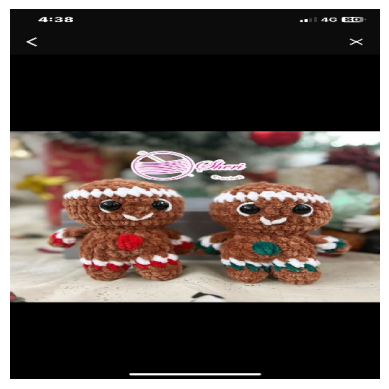

Predicted category: accessories
Prediction probabilities: [[0.21159899 0.3186579  0.4697432 ]]


In [18]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image
# Load the trained model

# Load and preprocess the image
img_path = r"C:\Users\Ziad\Downloads\WhatsApp Image 2024-03-20 at 4.38.30 PM.jpeg"
img = image.load_img(img_path, target_size=(512, 512))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.  # Normalize pixel values

# Make predictions
predictions = model.predict(img_array)

# Get the predicted category
predicted_class = np.argmax(predictions)
# Optionally, get the class labels associated with your categories
class_labels = ['fashion', 'nutrition', 'accessories']  # Update with your actual class labels
predicted_label = class_labels[predicted_class]

plt.imshow(img)
plt.axis('off')  
plt.show()

print(f'Predicted category: {predicted_label}')
print(f'Prediction probabilities: {predictions}')
